In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

import numpy as np
import timm
from tqdm.notebook import tqdm
import glob
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


In [3]:
# GETTING THE LABELS AND IMAGE_DIRS
data = pd.read_csv("labels.csv")
ids = data["ImageID"]
labels = data["Labels"]
ids = list(ids)
labels = list(labels)

C:\Users\Urahara Kiseke\AppData\Local\Temp\ipykernel_12248\4252568107.py:2: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("labels.csv")


# Getting the model and data ready

In [4]:
# Getting the file paths

import cv2
# target_labels = ["normal", "infiltrates", "cardiomegaly"]
train_dir = "./0"
image_dirs = glob.glob(train_dir + "\*.*")
# filtered_image_dirs = []
# for i in range(len(train_image_dirs)):
    # if (train_image_dirs[i][4:] in filtered_ids):
        # filtered_image_dirs.append(train_image_dirs[i])
# print(filtered_image_dirs)
print(image_dirs)

['./0\\100069103068753688347522093561206841448_7197k3.png', './0\\100081820231385537397079729591266436694_8o3uj2.png', './0\\100360992970443012139948853258191567510_orx7ef.png', './0\\100691695037268283818623526399976469181_adj3tf.png', './0\\100702512704517523898043432543968415038_8gt6pb.png', './0\\101408931302974623103956952273007774313_9stb1t.png', './0\\101408931302974623103956952273007774313_9stb1v.png', './0\\101452115716674895724726750589547378043_brve9k.png', './0\\101452115716674895724726750589547378043_brve9m.png', './0\\101892477424645152745400052582148736248_p9aiil.png', './0\\101892477424645152745400052582148736248_p9f34r.png', './0\\102102747557522113902850993567166035648_-5a78l.png', './0\\102185472428957491598043403159908631419_zb8kcm.png', './0\\102185472428957491598043403159908631419_zb8kco.png', './0\\102255812911480982201406764814400797841_b7jtf8.png', './0\\102287872353200883506852217101298313787_eifljr.png', './0\\102287872353200883506852217101298313787_eiwu70.pn

In [5]:
ids = list(ids)
print(ids.index('100069103068753688347522093561206841448_7197k3.png'))

2602


# Reading the unique_labels into list

In [6]:
file = open("unique_labels.txt", 'r')
data = file.read()
unique_labels = data.split('\n')
unique_labels.remove('')
print(unique_labels)

['normal', 'pulmonary fibrosis', 'chronic changes', 'kyphosis', 'pseudonodule', 'ground glass pattern', 'unchanged', 'alveolar pattern', 'interstitial pattern', 'laminar atelectasis', 'pleural effusion', 'apical pleural thickening', 'suture material', 'sternotomy', 'endotracheal tube', 'infiltrates', 'heart insufficiency', 'hemidiaphragm elevation', 'superior mediastinal enlargement', 'aortic elongation', 'scoliosis', 'sclerotic bone lesion', 'supra aortic elongation', 'vertebral degenerative changes', 'goiter', 'COPD signs', 'air trapping', 'descendent aortic elongation', 'aortic atheromatosis', 'metal', 'hypoexpansion basal', 'abnormal foreign body', 'central venous catheter via subclavian vein', 'central venous catheter', 'vascular hilar enlargement', 'pacemaker', 'atelectasis', 'vertebral anterior compression', 'hiatal hernia', 'pneumonia', 'diaphragmatic eventration', 'consolidation', 'calcified densities', 'cardiomegaly', 'fibrotic band', 'tuberculosis sequelae', 'volume loss', '

# Splitting the dataset into train & test

In [7]:
# Splitting the dataset
from torch.utils.data import random_split
train_size = int(0.8 * len(image_dirs))
valid_size = len(image_dirs) - train_size

train_image_dirs, valid_image_dirs= random_split(image_dirs, [train_size, valid_size])
print(len(train_image_dirs), len(valid_image_dirs))

2403 601


C:\Users\Urahara Kiseke\AppData\Local\Temp\ipykernel_12248\551504697.py:1: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data_csv = pd.read_csv("labels.csv")


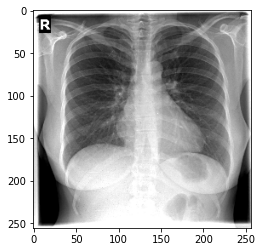

In [8]:
data_csv = pd.read_csv("labels.csv")
def convert_label(label):
    label = label.replace('[', '')
    label = label.replace(']', '')
    label = label.replace(" ' ", "")
    label = label.replace(" '", "")
    label = label.replace("' ", "")
    label = label.replace("'", "")
    return label
class lung_classifier(Dataset):
    def __init__(self, image_dirs, labels):
        # get all nessesary inputs like train directories and labels
        self.image_dirs = image_dirs
        self.labels = labels
        self.labels = np.asarray(self.labels)
    def __len__(self):
        #return the length of the dataset
        return len(self.image_dirs)
    def get_one_hot_encoding(self, label):
        label = label.split(",")
        one_hot = [l == self.labels for l in label]
        one_hot = np.array(one_hot)
        one_hot_encoded = np.zeros(one_hot[0].shape)
        for i in one_hot:
            one_hot_encoded = np.add(i, one_hot_encoded)
        return one_hot_encoded
    def __getitem__(self, id):
        # get the data id
        image = self.image_dirs[id]
        label = data_csv["Labels"][ids.index(image[4:])]
        label = convert_label(label)
        # print the image
        img = cv2.imread(image)
        img = cv2.resize(img, (256, 256))
        img = img.transpose((2, 0, 1))
        img = torch.tensor(img, dtype = torch.float)
        self.get_one_hot_encoding(label)
        one_hot = self.get_one_hot_encoding(label)
        one_hot = torch.tensor(one_hot, dtype = torch.float)
        return img/255.0, one_hot

train_dataset = lung_classifier(train_image_dirs, unique_labels)
valid_dataset = lung_classifier(valid_image_dirs, unique_labels)
img, label = valid_dataset.__getitem__(100)
img = img.numpy().transpose(1, 2, 0)
plt.imshow(img)

In [9]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size = 8,
    shuffle = True
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size = 8,
    shuffle = True
)


In [29]:
class lungDiseaseClassifier(nn.Module):
    def __init__(self, num_classes):
        # defining the necessary layers
        super().__init__()
        self.num_classes = num_classes
        self.model = timm.create_model("inception_resnet_v2", pretrained = True)
        self.model.classif = nn.Linear(self.model.classif.in_features, out_features=num_classes)
    def forward(self, X):
        # define forward here
        return F.softmax(self.model(X), dim=-1)
model = lungDiseaseClassifier(len(unique_labels)).to(DEVICE)

# Optimizer and Loss Function

In [11]:

optimizer = Adam(lr = 0.001, params = model.parameters())
def loss_fn(y_pred, y_true):
    # define your loss function here
    y_pred = torch.clip(y_pred, 1e-8, 1-(1e-8))
    l = y_true*torch.log(y_pred)
    l = l.sum(dim = -1)
    l = l.mean()
    return -l

In [12]:
t_loss = []
t_acc = []
v_loss = []
v_acc = []

In [13]:
def train_on_one_epoch(dataloader, optimizer, loss_fn, len_dataloader):
    dataloader = tqdm(dataloader)
    L = 0
    acc = 0
    for i, (x, y) in enumerate(dataloader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        y_pred = model(x)
        l = loss_fn(y_pred, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        L+=l.item()
        acc+=np.sum(y_pred.cpu().detach().numpy().argmax(-1) == y.cpu().detach().numpy().argmax(-1))
    return L/len_dataloader, acc/len_dataloader
def valid_on_one_epoch(dataloader, loss_fn, len_dataloader):
    dataloader = tqdm(dataloader)
    L = 0
    acc = 0
    for i, (x, y) in enumerate(dataloader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        y_pred = model(x)
        l = loss_fn(y_pred, y)
        L+=l.item()
        acc+=np.sum(y_pred.cpu().detach().numpy().argmax(-1) == y.cpu().detach().numpy().argmax(-1))
    return L/len_dataloader, acc/len_dataloader

prev_valid_acc = 0
patience = 0
patience_counter = 0
for epoch in range(50):
    train_loss, train_acc = train_on_one_epoch(train_dataloader, optimizer, loss_fn, len(train_dataset))
    valid_loss, valid_acc = valid_on_one_epoch(valid_dataloader, loss_fn, len(valid_dataloader))
    t_loss.append(train_loss)
    t_acc.append(train_acc)
    v_loss.append(valid_loss)
    v_acc.append(valid_acc)
    print(f"epoch: {epoch} | train loss : {train_loss} | valid loss : {valid_loss} | train acc : {train_acc} | valid acc : {valid_acc}")
    if prev_valid_acc < valid_acc:
        torch.save(model.state.dict(), "best.pt")
        print("model saved!!")
        prev_valid_acc = valid_acc
        patience_counter = 0
    else:
        patience_counter += 1
        if (patience_counter >= patience):
            print(f"Early stopping after {epoch} epochs.")
            break
        

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/76 [00:01<?, ?it/s]

epoch: 0 | train loss : 1.0958709033191378 | valid loss : 8.604959318512364 | train acc : 0.27340823970037453 | valid acc : 1.894736842105263


NameError: name 'pre_valid_acc' is not defined

# Plotting the losses & accuracy

Text(0.5, 1.0, 'valid_loss')

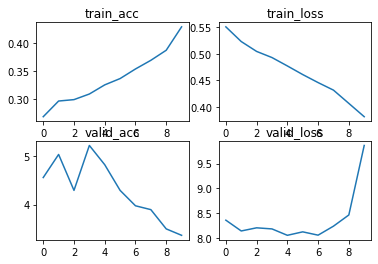

In [27]:
def convert_to_float(input_list):
    for i in range(len(input_list)):
        input_list[i] = float(input_list[i])
    return input_list
def reading_list(file_name):
    reading_list = []
    file = open(file_name, "r")
    reading_list = file.read()
    reading_list = reading_list.split('\n')
    reading_list.remove('')
    reading_list = convert_to_float(reading_list)
    return reading_list
def plotting_graph(plot_list, title):
    plt.title(title)
    plt.plot(plot_list)


t_acc = reading_list("train_acc.txt")
t_loss = reading_list("train_loss.txt")
v_acc = reading_list("valid_acc.txt")
v_loss = reading_list("valid_loss.txt")
# plotting_graph(t_loss, "train_loss")
# plotting_graph(t_acc, "train_accuracy")
# plotting_graph(v_loss, "valid_loss")
# plotting_graph(v_acc, "valid_accuracy")

figure, axis = plt.subplots(2, 2)
axis[0, 0].plot(t_acc)
axis[0, 0].set_title("train_acc")

axis[0, 1].plot(t_loss)
axis[0, 1].set_title("train_loss")

axis[1, 0].plot(v_acc)
axis[1, 0].set_title("valid_acc")

axis[1, 1].plot(v_loss)
axis[1, 1].set_title("valid_loss")
